In [1]:
# Import all packages

import os
os.chdir('/home/scur2012/Thesis/master-thesis/experiments/tmnre')

import numpy as np
import pandas as pd
import zarr
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import swyft.lightning as sl



import gw_parameters
import importlib
importlib.reload(gw_parameters)


<module 'gw_parameters' from '/gpfs/home3/scur2012/Thesis/master-thesis/experiments/tmnre/gw_parameters.py'>

In [2]:
# Initialise configuration settings

conf = gw_parameters.default_conf
bounds = gw_parameters.limits

In [3]:
# Load swyft-based simulator. 
# This builds the framework for the computational DAG

import peregrine_simulator
importlib.reload(peregrine_simulator)
from peregrine_simulator import Simulator

swyft_simulator = Simulator(conf, bounds)

In [4]:
# Generate ground-truth observation

obs = swyft_simulator.generate_observation()

# Convert observation to swyft type sample

obs_sample = sl.Sample(
    {key: obs[key] for key in ["d_t", "d_f", "d_f_w", "n_t", "n_f", "n_f_w"]}
)

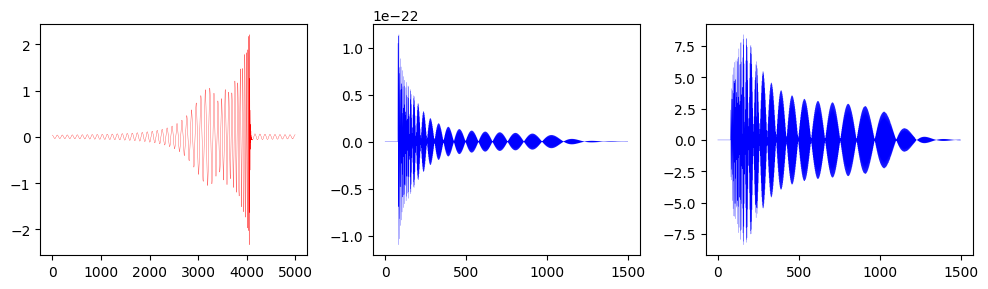

In [5]:
# Plot signal

import matplotlib.pyplot as plt

# Create a figure and two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))  # 1 row, 2 columns, optional figure size

# Plot data on the first subplot
ax1.plot(obs['d_t'][0][:5000], 'r-', linewidth=0.2)
ax2.plot(obs['d_f'][0][:1500], 'b-', linewidth=0.2)
ax3.plot(obs['d_f_w'][0][:1500], 'b-', linewidth=0.2)
plt.tight_layout()
plt.show()

In [6]:
# Set up the zarr store

zarr_store_dirs = '/scratch-shared/scur2012/peregrine_data/tmnre_experiments'
name_of_run = 'peregrine_copy_highSNR'
rnd_id = 1
simulation_store_path = f"{zarr_store_dirs}/{name_of_run}/simulations/round_{rnd_id}"

number_of_simulations = 1000
shapes, dtypes = swyft_simulator.get_shapes_and_dtypes()
shapes.pop("n")
dtypes.pop("n")

chunk_size = 1000
zarr_store = sl.ZarrStore(f"{simulation_store_path}")
zarr_store.init(
    N=number_of_simulations, 
    chunk_size=chunk_size, 
    shapes=shapes,
    dtypes=dtypes)

In [7]:
# Generate the random observations and save the data to the zarr store
import multiprocessing
import time

njobs = 1
batches = [chunk_size] * ( number_of_simulations // chunk_size ) + [number_of_simulations % chunk_size]

def populate_zarr_simulation(n_sims):
    zarr_store.simulate(
        sampler=swyft_simulator,
        batch_size=n_sims,
        max_sims=n_sims,
    )

# Creating a pool of worker processes
with multiprocessing.Pool(njobs) as pool:
    results = pool.map(populate_zarr_simulation, batches)


In [8]:
from random import random
random()

0.18057006632066053

In [9]:
zarr_store['z_total'][0]

array([ 5.6722206e-01,  4.0308350e+01,  2.7958412e+00,  3.9966302e+00,
        1.6727996e+00,  1.2742697e+00,  3.1583905e-01,  9.7963363e-02,
        1.7191103e+00,  1.7668808e+00,  8.1651331e+02,  1.5261976e-01,
        4.7731833e+00,  2.4624453e+00, -6.4385243e-02], dtype=float32)

In [10]:
# Initialise data loader for training network

network_settings = dict(
    min_epochs = 1,
    max_epochs = 10,
    early_stopping = 7,
    learning_rate = 5e-4,
    num_workers = 8,
    training_batch_size = 1,
    validation_batch_size = 1,
    train_split = 0.9,
    val_split = 0.1,
    shuffling = True,
    priors = dict(
        int_priors = conf['priors']['int_priors'],
        ext_priors = conf['priors']['ext_priors'],
    ),
    marginals = (0,1),
    one_d_only = True,
    ifo_list = conf["waveform_params"]["ifo_list"],
)

train_data = zarr_store.get_dataloader(
    num_workers=network_settings['num_workers'],
    batch_size=network_settings['training_batch_size'],
    idx_range=[0, int(network_settings['train_split'] * len(zarr_store.data.z_int))],
    on_after_load_sample=False,
)

val_data = zarr_store.get_dataloader(
    num_workers=network_settings['num_workers'],
    batch_size=network_settings['validation_batch_size'],
    idx_range=[
        int(network_settings['train_split'] * len(zarr_store.data.z_int)),
        len(zarr_store.data.z_int) - 1,
    ],
    on_after_load_sample=None,
)

training_store_path = f"{zarr_store_dirs}/{name_of_run}/training"
round_id = 1

In [12]:
# Set up the pytorch trainer settings

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

lr_monitor = LearningRateMonitor(logging_interval="step")
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=network_settings["early_stopping"],
    verbose=False,
    mode="min",
)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=f"{training_store_path}",
    filename="{epoch}_{val_loss:.2f}_{train_loss:.2f}" + f"_R{round_id}",
    mode="min",
)
logger_tbl = pl_loggers.TensorBoardLogger(
    save_dir=f"{training_store_path}",
    name=f"test_R{round_id}",
    version=None,
    default_hp_metric=False,
)

swyft_trainer = sl.SwyftTrainer(
    accelerator='gpu',
    gpus=1,
    min_epochs=network_settings["min_epochs"],
    max_epochs=network_settings["max_epochs"],
    logger=logger_tbl,
    callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback],
)

/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/scur2012/Thesis/master-thesis/.venv/lib/python ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
import peregrine_network
importlib.reload(peregrine_network)
from peregrine_network import InferenceNetwork

rnd_id = 1

# Test the network
match rnd_id:
    case 1: ckpt = 'epoch=67_val_loss=-3.51_train_loss=-3.51_round_1.ckpt'
    case 2: ckpt = 'epoch=62_val_loss=-7.97_train_loss=-7.31_round_2.ckpt'
    case 3: ckpt = 'epoch=49_val_loss=-5.13_train_loss=-6.99_round_3.ckpt'
    case 4: ckpt = 'epoch=17_val_loss=-3.08_train_loss=-4.21_round_4.ckpt'
    case 5: ckpt = 'epoch=24_val_loss=-2.73_train_loss=-4.43_round_5.ckpt'
    case 6: ckpt = 'epoch=23_val_loss=-2.39_train_loss=-3.02_round_6.ckpt'
    case 7: ckpt = 'epoch=23_val_loss=-2.06_train_loss=-2.47_round_7.ckpt'
    case 8: ckpt = 'epoch=27_val_loss=-1.54_train_loss=-1.88_round_8.ckpt'

# Load network model
network = InferenceNetwork(network_settings)
swyft_trainer = sl.SwyftTrainer(resume_from_checkpoint = f"{zarr_store_dirs}/{name_of_run}/training/round_{rnd_id}/{ckpt}")

# Fit data to model
# swyft_trainer.fit(network, train_data, val_data)

# swyft_trainer.test(network, val_data)


/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:55: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v2.0. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [14]:
train_data

In [15]:
marginals_string = '(0,1)'
marginals_list = []
for marginal in marginals_string.split("("):
    split_marginal = marginal.split(")")
    if split_marginal[0] != "":
        indices = split_marginal[0].split(",")
        mg = []
        for index in indices:
            mg.append(int(index.strip(" ")))
        marginals_list.append(tuple(mg))
        
marginals = tuple(marginals_list)
tuple(marginals_list)

((0, 1),)

In [16]:
# Generate prior samples for testing the trained model
prior_simulator = Simulator(conf, bounds)
prior_samples = prior_simulator.sample(100_000, targets=["z_total"])

# Run model in inference mode
logratio_data = swyft_trainer.infer( 
    network, 
    obs_sample, 
    prior_samples.get_dataloader(batch_size=2048))

  0%|          | 0/100000 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [19]:
# Load data from disk

import zarr

zarr_store_dirs = '/scratch-shared/scur2012/peregrine_data/tmnre_experiments'
name_of_run = 'transformer_test_1'
rnd_id = 1

# Prior
saved_path = f"{zarr_store_dirs}/{name_of_run}/simulations/round_{rnd_id}"
simulation_results = zarr.convenience.open(saved_path)

import pickle
# Log ratios
logratio_path = f"{zarr_store_dirs}/{name_of_run}/logratios/round_{rnd_id}.pickle"

with open(logratio_path, 'rb') as f:
    logratio_data = pickle.load(f)

In [20]:
simulation_results['data']['z_total']

<zarr.core.Array '/data/z_total' (30000, 15) float32>

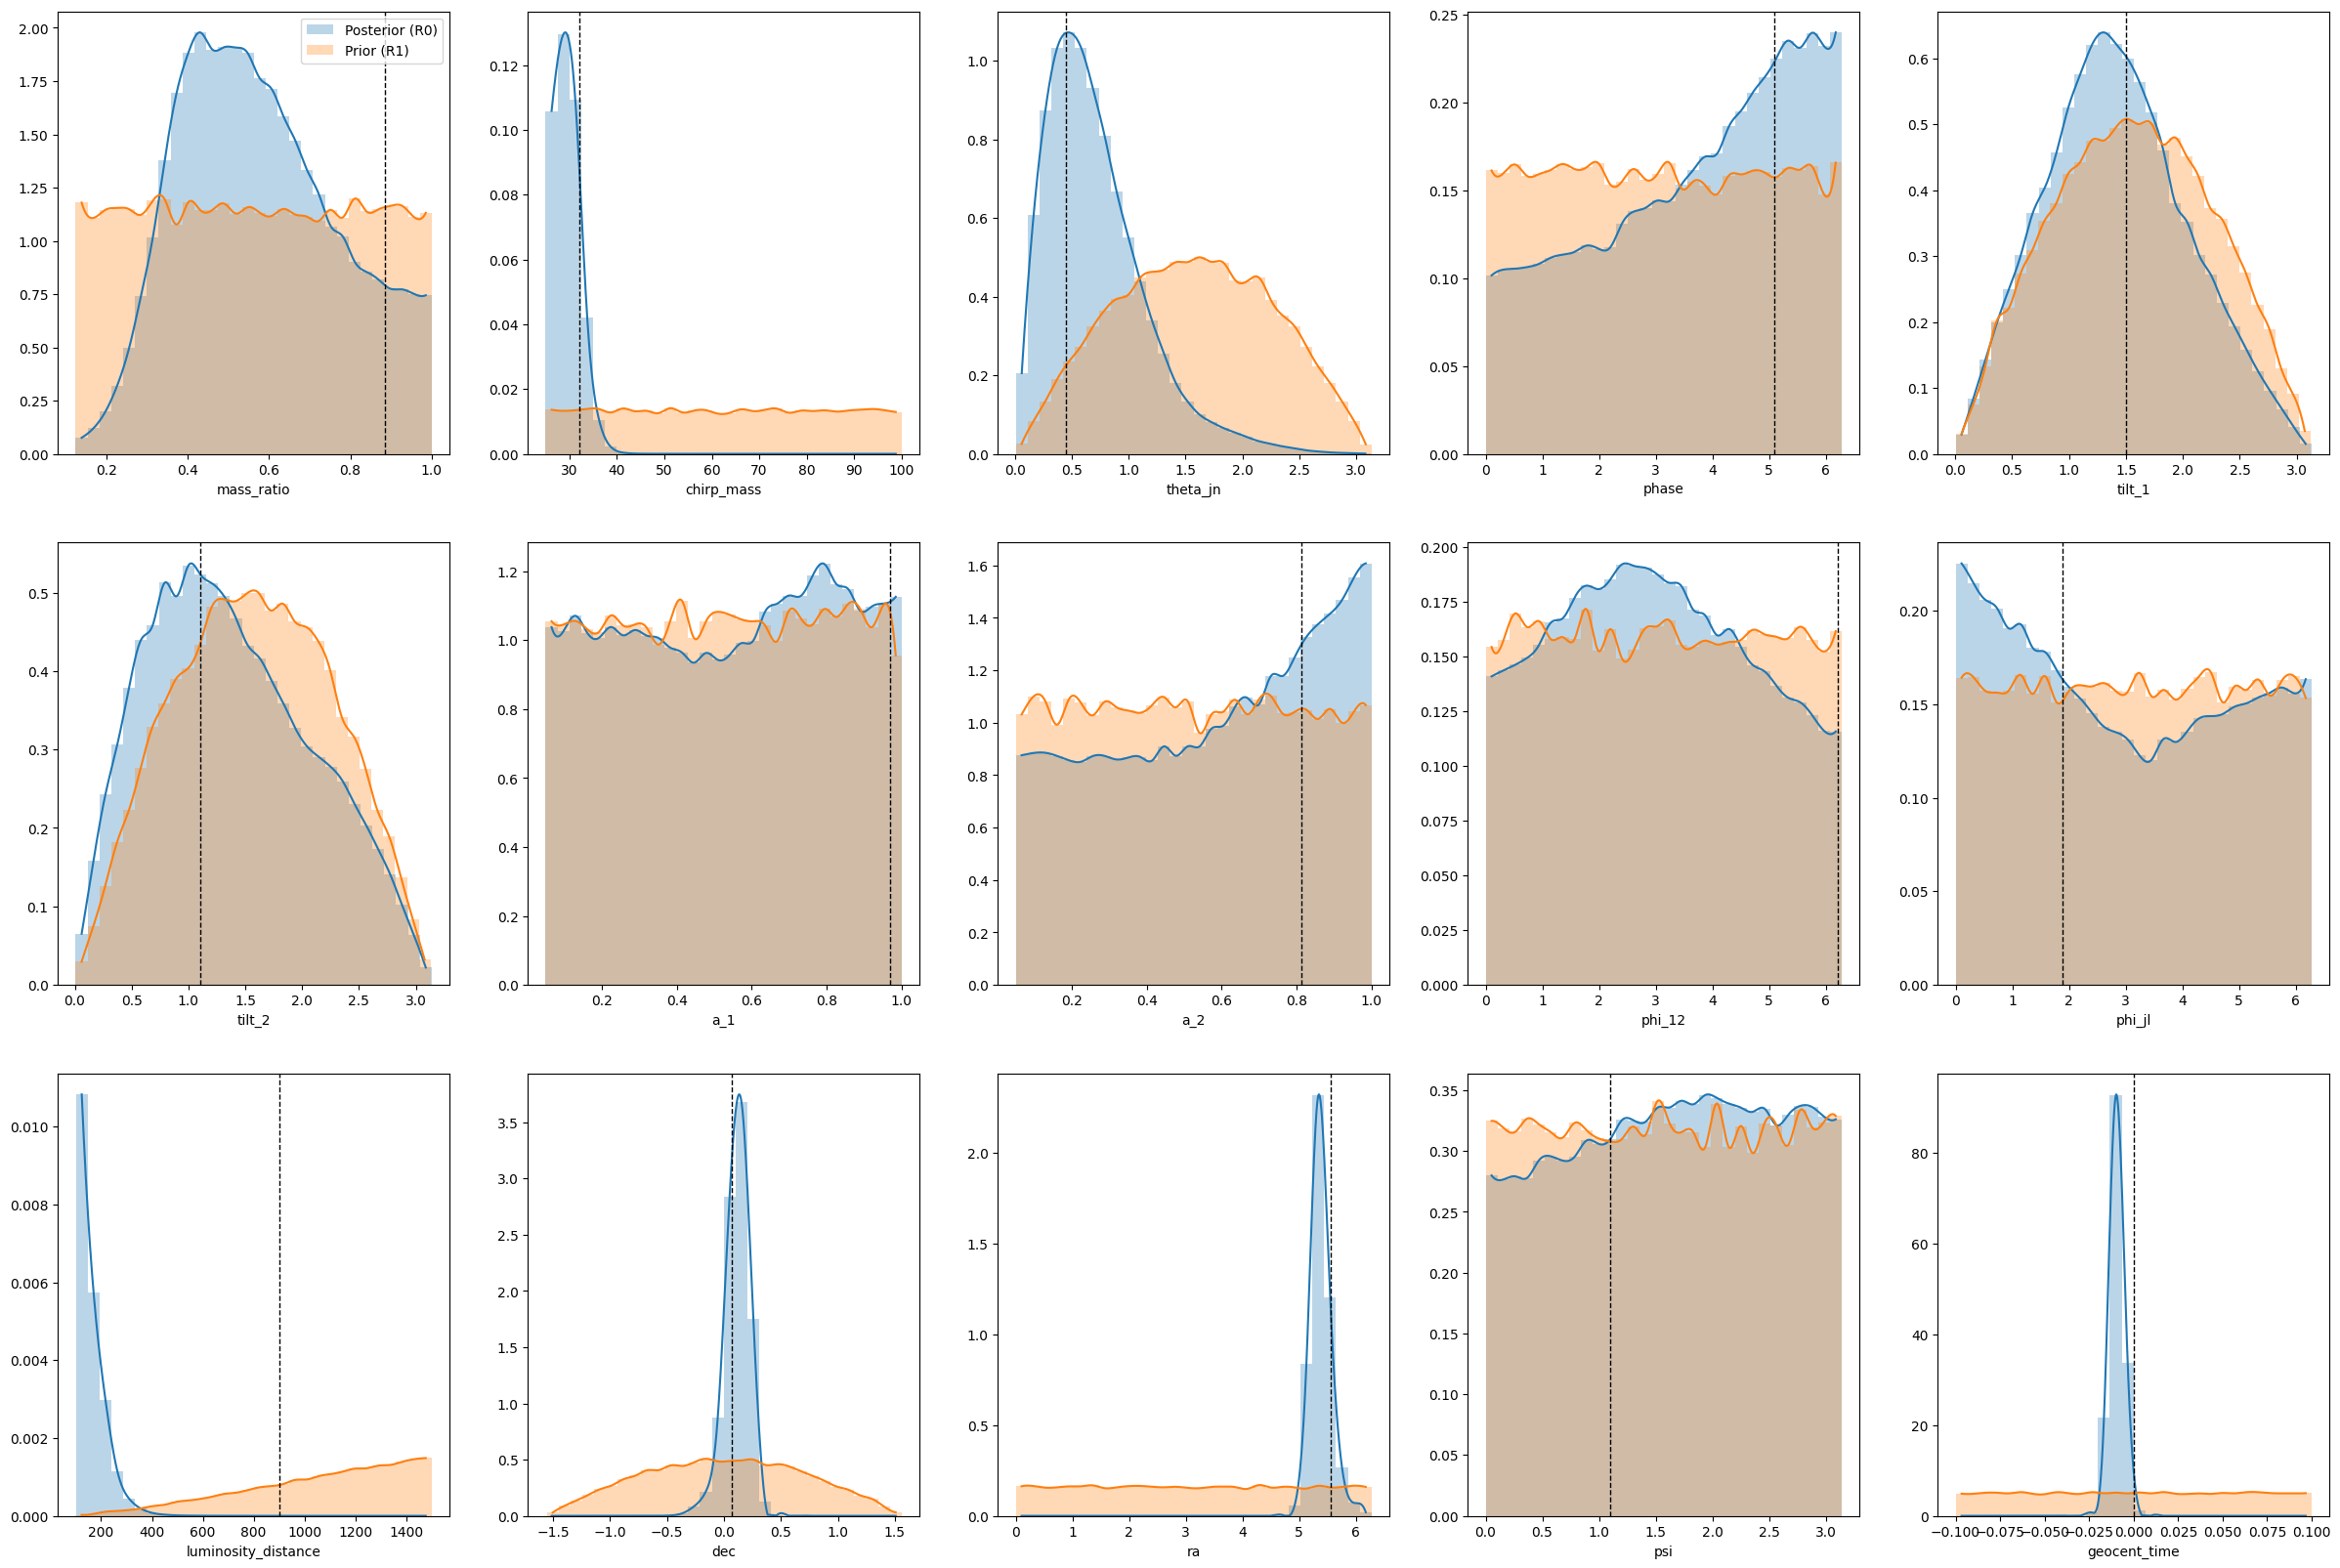

In [21]:
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

parameter_names = list(gw_parameters.default_injection.keys())
ground_truth = list(gw_parameters.default_injection.values())

plt.figure(figsize=(30, 20))
for p_id in range(15):
    
    # Posteriors plot
    
    ax = plt.subplot(3, 5, p_id + 1)
    plt.xlabel(parameter_names[p_id])

    logratios = logratio_data.logratios[:, p_id]
    sample = logratio_data.params[:, p_id, 0]
    h, bins = np.histogram(
        sample, weights=np.exp(logratios), density=True, bins=30
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
        label=f'Posterior (R{rnd_id-1})',
    )
    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=3, fill_value="extrapolate")

    x_grid = np.linspace(min1, max1, 1000)
    plt.plot(x_grid[fit1(x_grid)>0], fit1(x_grid)[fit1(x_grid)>0])
    
    # Priors plot
    
    sample = simulation_results['data']['z_total'][:, p_id]
        
    h, bins = np.histogram(
        sample, density=True, bins=30
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
        label=f'Prior (R{rnd_id})',
    )
    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=3, fill_value="extrapolate")
    
    if p_id == 0:
        plt.legend()
    x_grid = np.linspace(min1, max1, 1000)
    plt.plot(x_grid[fit1(x_grid)>0], fit1(x_grid)[fit1(x_grid)>0])
    
    # Add ground-truth
    plt.axvline(ground_truth[p_id], 0, 1, color='k', linestyle='--', linewidth=1)

plt.show()

In [28]:
import zarr
import pickle

# Compare with original peregrine

zarr_store_dirs = '/scratch-shared/scur2012/peregrine_data/tmnre_experiments/'
name_of_run = 'resnet_test_2'
rnd_id = 1

# Prior
saved_path = f"{zarr_store_dirs}/{name_of_run}/simulations/round_{rnd_id}"
simulation_results_me = zarr.convenience.open(saved_path)

# Log ratios
logratio_path = f"{zarr_store_dirs}/{name_of_run}/logratios/round_{rnd_id}.pickle"

if os.path.exists(logratio_path):
    with open(logratio_path, 'rb') as f:
        logratio_data_me = pickle.load(f)
        
# Re compute log ratios
#swyft_trainer = sl.SwyftTrainer()
#network = InferenceNetwork(network_settings)


# Prior
saved_path = f'/scratch-shared/scur2012/peregrine_data/bhardwaj2023_v2/simulations_highSNR_R{1}'
simulation_results_per = zarr.convenience.open(saved_path)

import pickle
# Posterior
logratio_path = f'/scratch-shared/scur2012/peregrine_data/bhardwaj2023_v2/logratios_highSNR/logratios_R{1}'

if os.path.exists(logratio_path):
    with open(logratio_path, 'rb') as f:
        logratio_data_per = pickle.load(f)


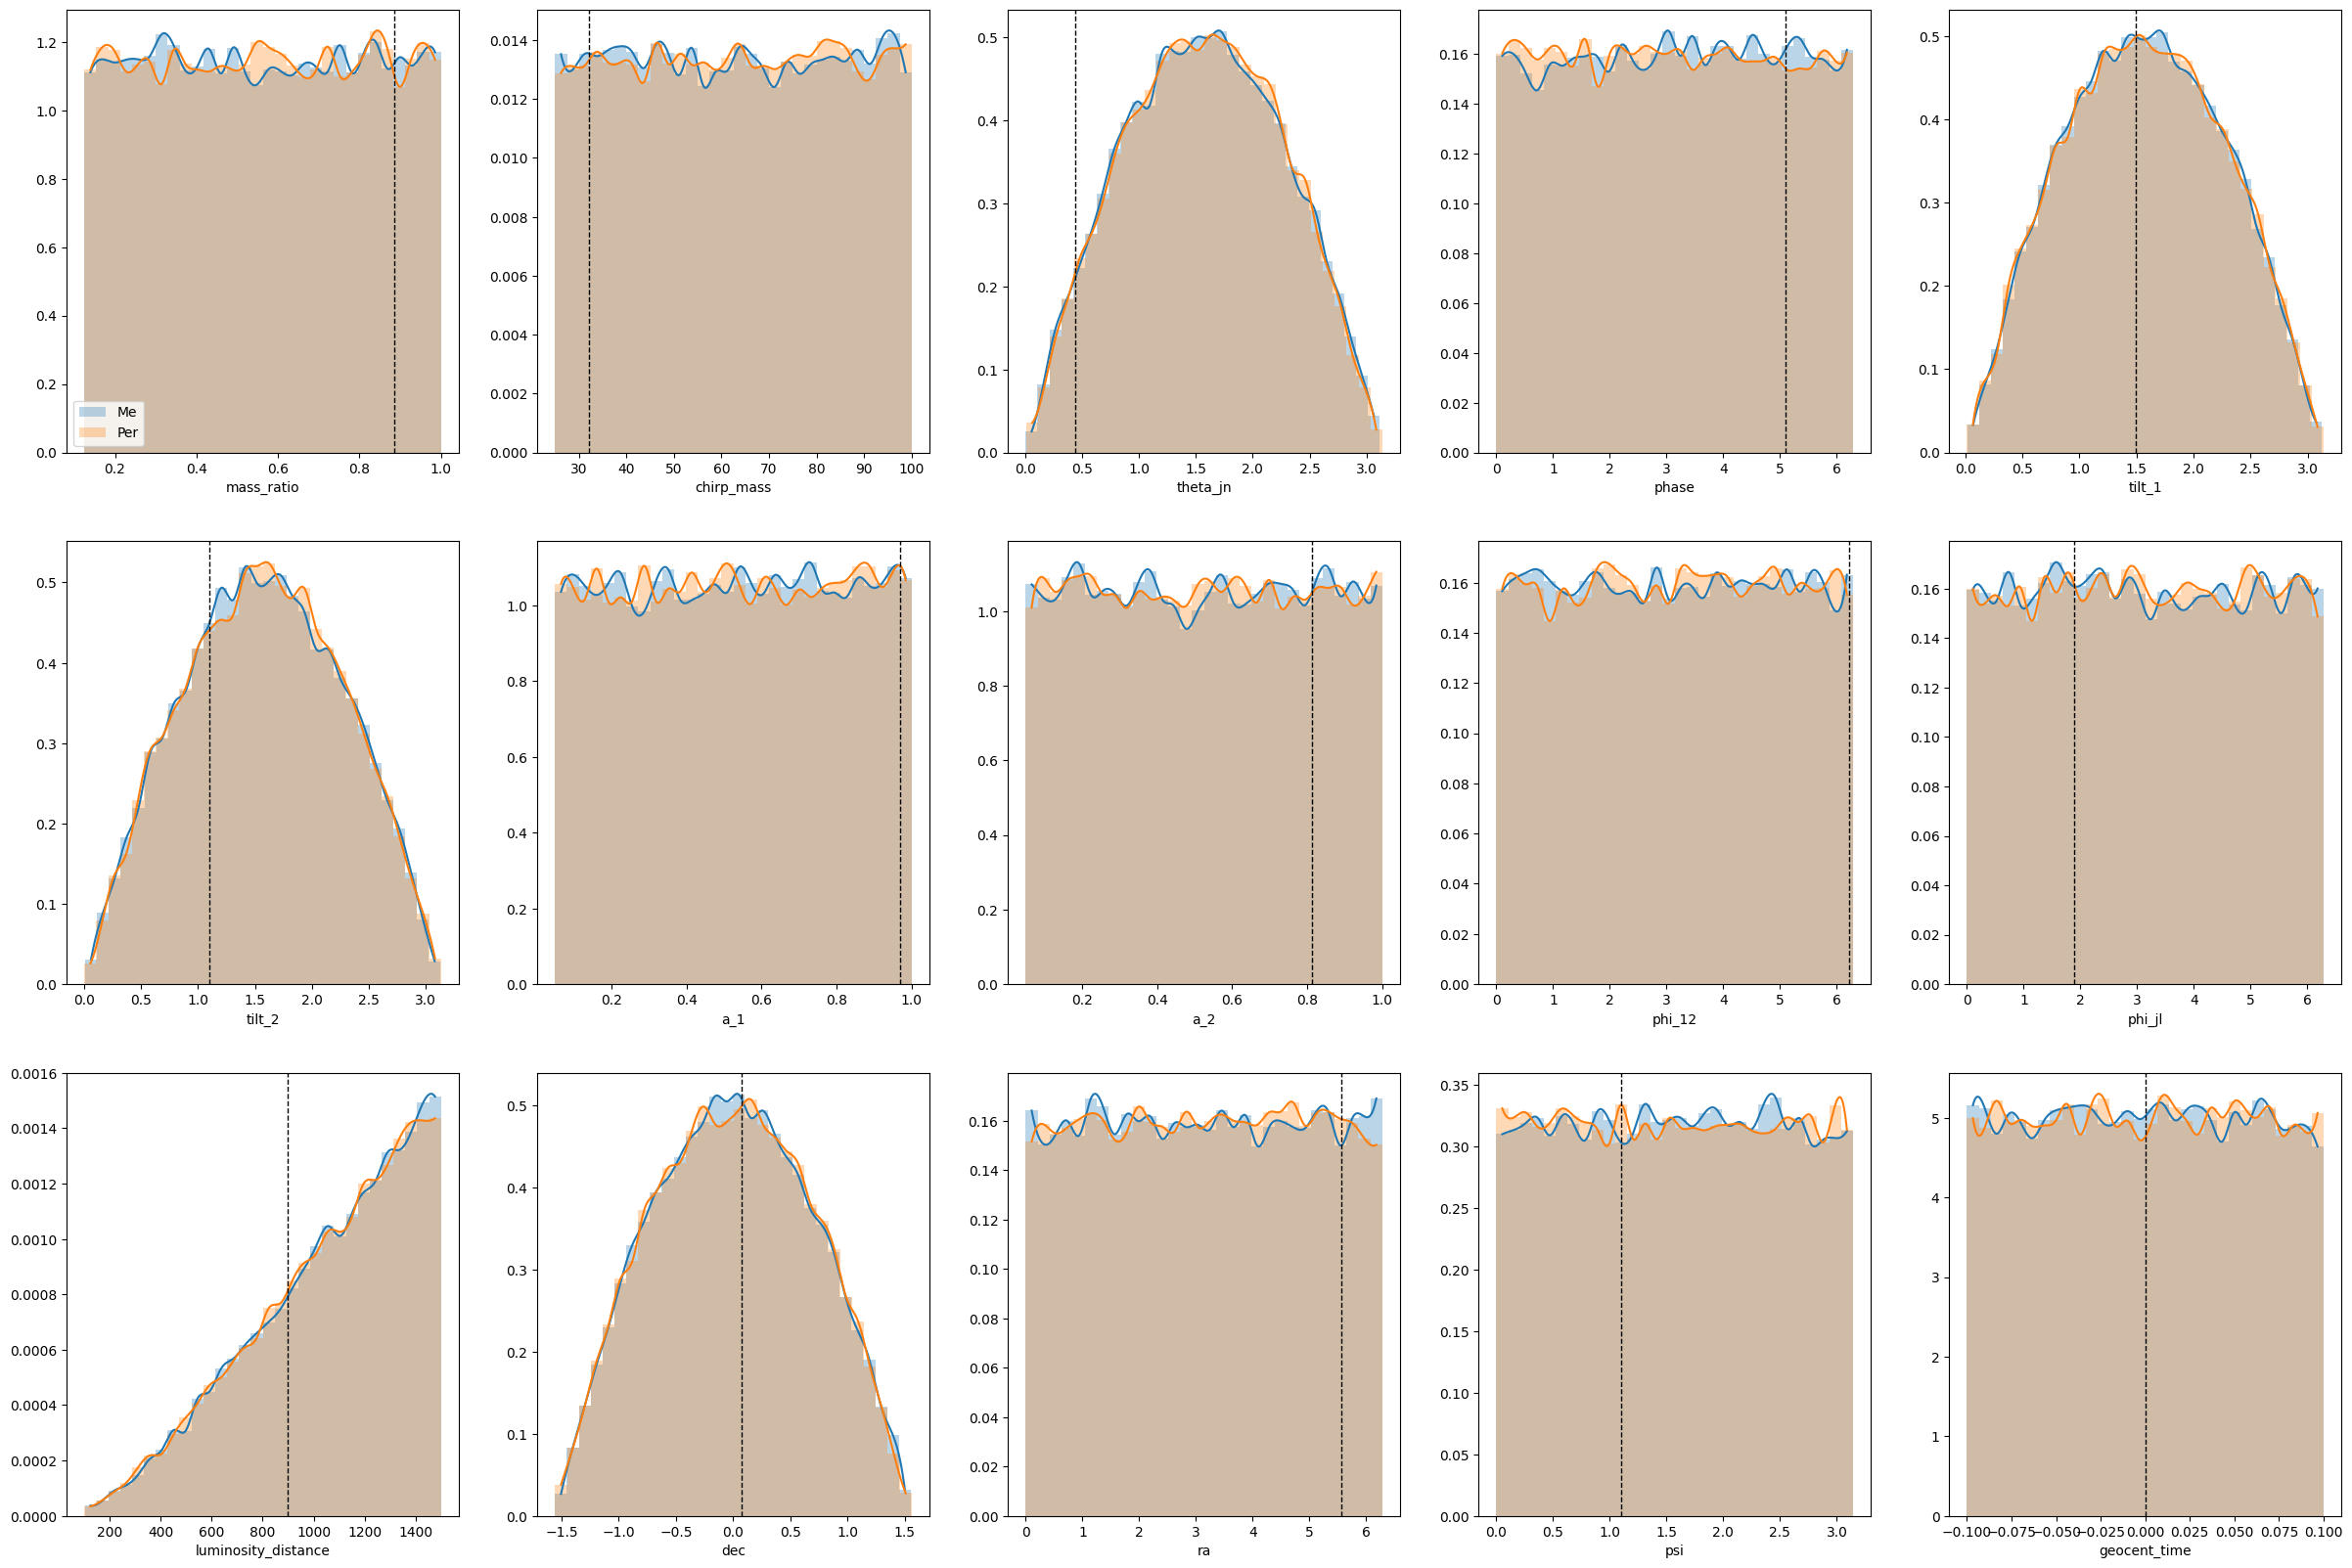

In [29]:
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

parameter_names = list(gw_parameters.default_injection.keys())
ground_truth = list(gw_parameters.default_injection.values())

# Compare priors

parameter_me = list(gw_parameters.default_injection.keys())

parameter_per = pd.read_table(f'/scratch-shared/scur2012/peregrine_data/bhardwaj2023/param_idxs_highSNR.txt', 
                                sep = r'\s+', usecols=[0,1], header=None).set_index(1).values[:,0]



plt.figure(figsize=(30, 20))
for p_id in range(15):

    ax = plt.subplot(3, 5, p_id + 1)
    plt.xlabel(parameter_names[p_id])

    # Priors plot
    
    # My results
    samples_me = simulation_results_me['data']['z_total'][:, p_id]
    
    h, bins = np.histogram(samples_me[samples_me!=0], density=True, bins=30)
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
        label=f'Me',
    )
        
    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=3, fill_value="extrapolate")
    x_grid = np.linspace(min1, max1, 1000)
    plt.plot(x_grid[fit1(x_grid)>0], fit1(x_grid)[fit1(x_grid)>0])
    
    # Peregrine results
    sample_per = simulation_results_per['data']['z_total'][:, p_id]
    
    h, bins = np.histogram(sample_per, density=True, bins=30)
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
        label=f'Per',
    )
    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=3, fill_value="extrapolate")
    
    if p_id == 0:
        plt.legend()
    x_grid = np.linspace(min1, max1, 1000)
    plt.plot(x_grid[fit1(x_grid)>0], fit1(x_grid)[fit1(x_grid)>0])
    
    # Add ground-truth
    plt.axvline(ground_truth[p_id], 0, 1, color='k', linestyle='--', linewidth=1)

plt.show()

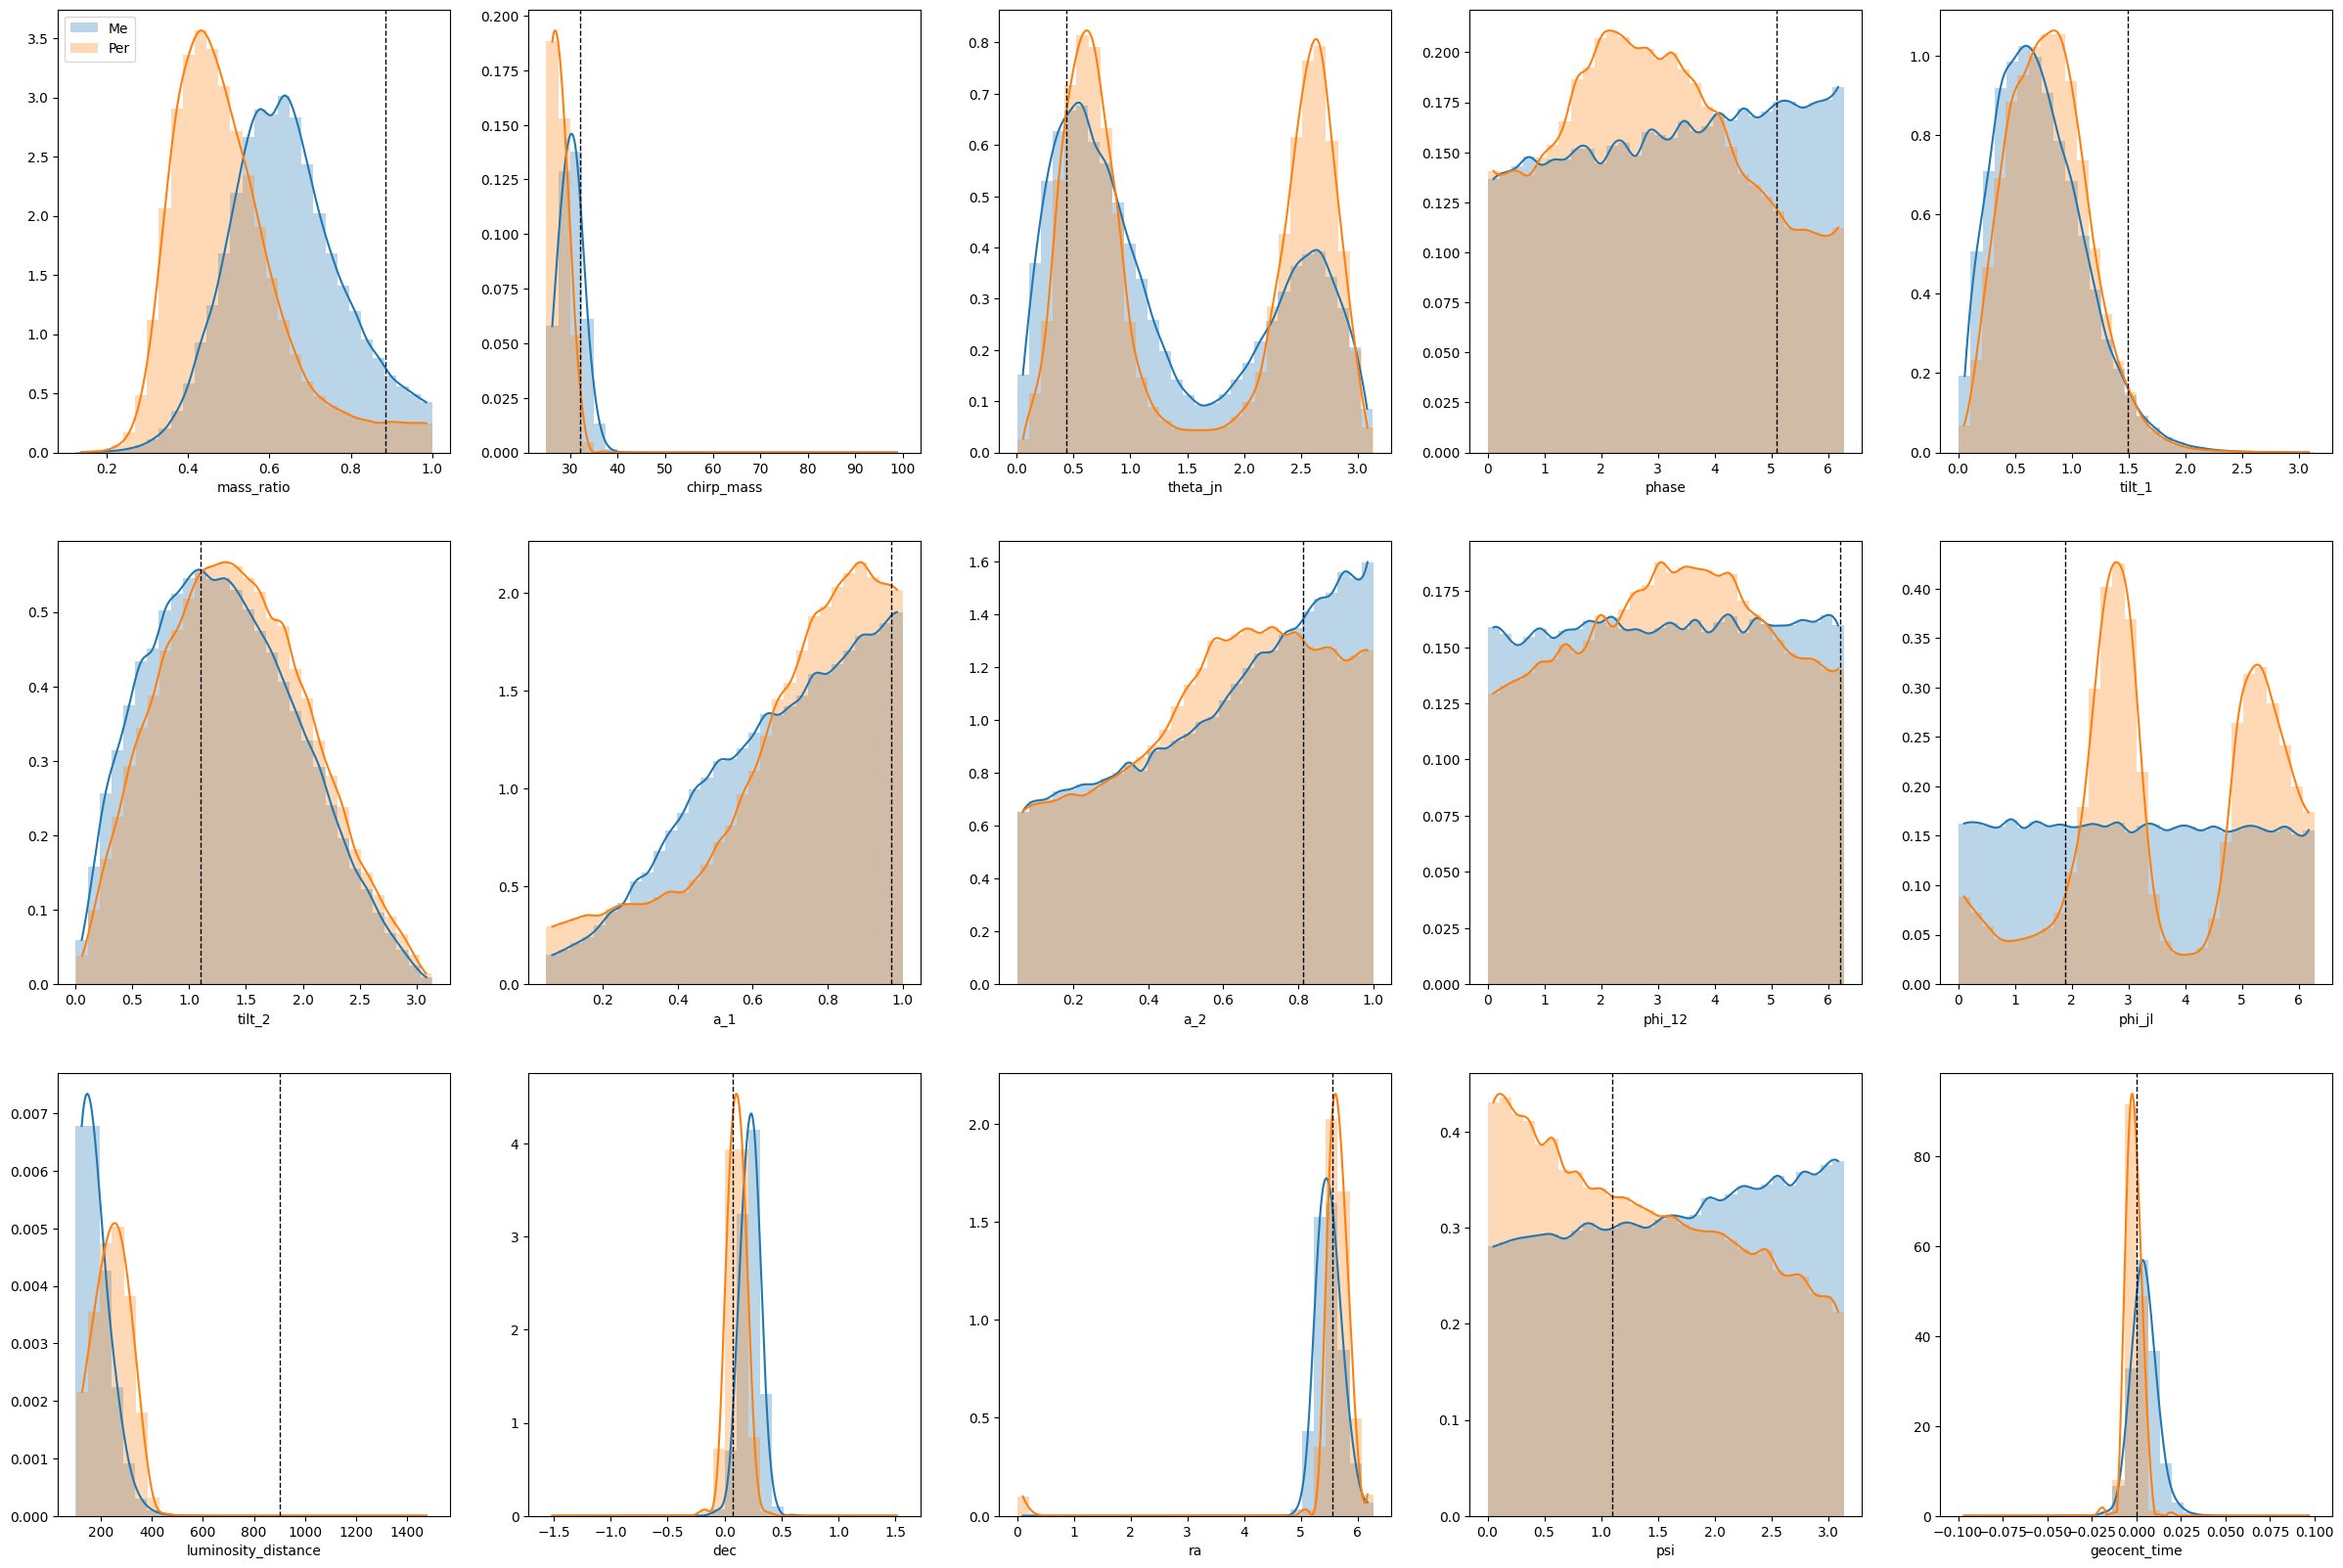

In [30]:
# Compare posteriors

parameter_me = list(gw_parameters.default_injection.keys())[2:]

parameter_per = pd.read_table(f'/scratch-shared/scur2012/peregrine_data/bhardwaj2023/param_idxs_highSNR.txt', 
                                sep = r'\s+', usecols=[0,1], header=None).set_index(1).values[:,0]

plt.figure(figsize=(30, 20))
for p_id in range(15):

    ax = plt.subplot(3, 5, p_id + 1)
    plt.xlabel(parameter_names[p_id])

    # Posteriors plot
    
    # My results
    logratios = logratio_data_me.logratios[:, p_id]
    sample = logratio_data_me.params[:, p_id, 0]
    h, bins = np.histogram(
        sample, weights=np.exp(logratios), density=True, bins=30
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
        label=f'Me',
    )
        
    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=3, fill_value="extrapolate")
    x_grid = np.linspace(min1, max1, 1000)
    plt.plot(x_grid[fit1(x_grid)>0], fit1(x_grid)[fit1(x_grid)>0])
    
    # Peregrine results
    logratios = logratio_data_per.logratios[:, p_id]
    sample = logratio_data_per.params[:, p_id, 0]
    h, bins = np.histogram(
        sample, weights=np.exp(logratios), density=True, bins=30
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
        label=f'Per',
    )
    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=3, fill_value="extrapolate")
    
    if p_id == 0:
        plt.legend()
    x_grid = np.linspace(min1, max1, 1000)
    plt.plot(x_grid[fit1(x_grid)>0], fit1(x_grid)[fit1(x_grid)>0])
    
    # Add ground-truth
    plt.axvline(ground_truth[p_id], 0, 1, color='k', linestyle='--', linewidth=1)
    

In [31]:
new_bounds = sl.bounds.get_rect_bounds(logratio_data_me, 1e-6).bounds.squeeze(1).numpy()

In [32]:
new_bounds

array([[ 1.2500033e-01,  9.9999791e-01],
       [ 2.5000963e+01,  5.0864616e+01],
       [ 5.5331667e-03,  3.1305463e+00],
       [ 7.2346644e-05,  6.2831073e+00],
       [ 6.4933905e-03,  3.1378665e+00],
       [ 4.7798189e-03,  3.1373873e+00],
       [ 5.0000578e-02,  9.9999386e-01],
       [ 5.0011404e-02,  9.9999571e-01],
       [ 7.8891499e-05,  6.2831445e+00],
       [ 3.6868747e-05,  6.2830043e+00],
       [ 1.0057440e+02,  6.4934985e+02],
       [-6.7039788e-01,  1.3217046e+00],
       [ 2.0498566e-05,  6.2830739e+00],
       [ 4.8356520e-05,  3.1415803e+00],
       [-5.9874456e-02,  8.8907592e-02]], dtype=float32)

In [33]:
import multiprocessing
chunk_size = 1000
number_of_simulations = 30000
zarr_store = sl.ZarrStore("tmp_zarr")

njobs = 16
batches = [chunk_size] * ( number_of_simulations // chunk_size ) + [number_of_simulations % chunk_size]

def populate_zarr_simulation(n_sims):

    zarr_store.init(
        N=number_of_simulations, 
        chunk_size=chunk_size, 
        shapes=shapes,
        dtypes=dtypes)
    
    zarr_store.simulate(
        sampler=Simulator(conf, bounds),
        batch_size=n_sims,
        max_sims=n_sims,
    )
    
with multiprocessing.Pool(njobs) as pool:
    results = pool.map(populate_zarr_simulation, batches)

NameError: name 'shapes' is not defined